In [25]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import data_gen
import random

In [100]:
# Read data from csv files

bitcoin = pd.read_csv('../data/BCHAIN-MKPRU.csv', index_col='Date', parse_dates=True)
bitcoin.head()

,Value
Date,
2016-09-11,621.65
2016-09-12,609.67
2016-09-13,610.92
2016-09-14,608.82
2016-09-15,610.38


In [101]:
gold = pd.read_csv('../data/LBMA-GOLD.csv', index_col='Date', parse_dates=True)
gold.columns = ['Value']
gold.head()

,Value
Date,
2016-09-12,1324.60
2016-09-13,1323.65
2016-09-14,1321.75
2016-09-15,1310.80
2016-09-16,1308.35


<AxesSubplot:xlabel='Date'>

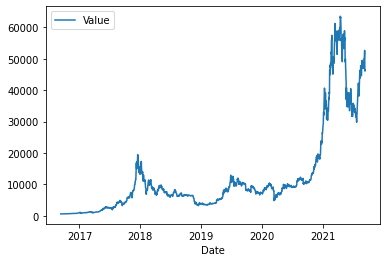

In [102]:
sns.lineplot(data=bitcoin)

<AxesSubplot:xlabel='Date'>

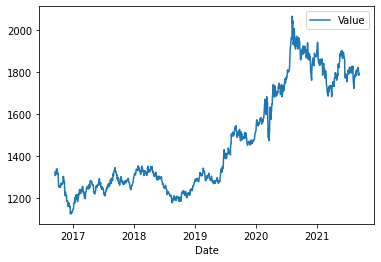

In [103]:
sns.lineplot(data=gold)

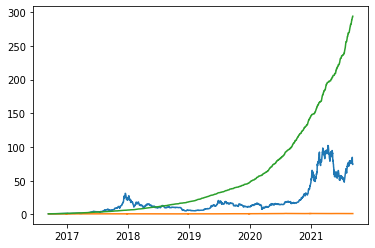

In [99]:
current_money = 1000
gold_rate, bit_rate = 0, 0


In [15]:

all_index = pd.date_range('2016-9-12', '2021-9-10', freq='D')
gold = gold.reindex(all_index)
gold.fillna(inplace=True, method='pad')
gold

,Value
2016-09-12,1324.60
2016-09-13,1323.65
2016-09-14,1321.75
2016-09-15,1310.80
2016-09-16,1308.35
...,...
2021-09-06,1821.60
2021-09-07,1802.15
2021-09-08,1786.00
2021-09-09,1788.25


In [31]:
b = data_gen.parse_df(bitcoin[1:], 4)
g = data_gen.parse_df(gold, 4)

In [32]:
b.head()

,high,low,open,close
Date,,,,
2016-09-12,610.92,608.82,609.67,610.38
2016-09-16,610.92,608.82,610.92,609.11
2016-09-20,610.38,607.04,608.82,607.04
2016-09-24,611.58,607.04,610.38,611.58
2016-09-28,611.58,607.04,609.11,610.19


In [33]:
g.head()

,high,low,open,close
2016-09-12,1324.60,1310.80,1324.60,1310.80
2016-09-16,1323.65,1308.35,1323.65,1308.35
2016-09-20,1321.75,1308.35,1321.75,1308.35
2016-09-24,1310.80,1308.35,1310.80,1308.35
2016-09-28,1314.85,1308.35,1308.35,1314.85


In [34]:
len(b)

456

In [35]:
len(g)

456

In [41]:
port = [['gold', 'btc'],['high', 'low', 'open', 'close']]

m_index = pd.MultiIndex.from_product(port, names=['Price', 'Feature'])

s = pd.concat((g, b), axis=1)
s.columns = m_index
s

Price          gold                                     btc             \
Feature        high      low     open    close         high        low   
2016-09-12  1324.60  1310.80  1324.60  1310.80    610.92000    608.820   
2016-09-16  1323.65  1308.35  1323.65  1308.35    610.92000    608.820   
2016-09-20  1321.75  1308.35  1321.75  1308.35    610.38000    607.040   
2016-09-24  1310.80  1308.35  1310.80  1308.35    611.58000    607.040   
2016-09-28  1314.85  1308.35  1308.35  1314.85    611.58000    607.040   
...             ...      ...      ...      ...          ...        ...   
2021-08-21  1255.00  1250.65  1255.00  1250.65  16860.88000  14869.805   
2021-08-25  1250.65  1247.15  1250.65  1247.15  16860.88000  14869.805   
2021-08-29  1250.65  1240.90  1250.65  1240.90  17276.39333  14869.805   
2021-09-02  1250.65  1240.90  1250.65  1242.65  17276.39333  14869.805   
2021-09-06  1251.00  1240.90  1247.15  1251.00  17276.39333  15068.950   

Price                                 
Feature            open        close  
2016-09-12    609.67000    610.38000  
2016-09-16    610.92000    609.11000  
2016-09-20    608.82000    607.04000  
2016-09-24    610.38000    611.58000  
2016-09-28    609.11000    610.19000  
...                 ...          ...  
2021-08-21  16501.97167  14869.80500  
2021-08-25  16860.88000  15068.95000  
2021-08-29  15142.83415  17276.39333  
2021-09-02  14869.80500  16808.36667  
2021-09-06  15068.95000  16252.31000  

[456 rows x 8 columns]